# LightGBM

LightGBM is an open-source framework for gradient boosted machines. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).


The framework is fast and was designed for distributed training. It supports large-scale datasets and training on the GPU. In many cases LightGBM has been found to be more accurate and faster than XGBoost, though this is problem dependent.


Both LightGBM and XGBoost are widely used and provide highly optimized, scalable and fast implementations of gradient boosted machines (GBMs). I have previously used XGBoost for a number of applications, but have yet to take an in depth look at LightGBM.


In [7]:
# importing sys
import sys
  
# adding srcpy to the system path
sys.path.insert(0, "/Users/charles/Desktop/iFixerup/zr1/src/srcpy/")

import data_proc, feature_proc, lgbm_mod

# Auto reload: watch a directory for changed files and restarts a process when the change is detected
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import random
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
pd.options.display.float_format

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
mpl.style.use("ggplot")
pylab.rcParams["figure.figsize"] = 8 , 6

import seaborn as sns
sns.set_style("white")

In [9]:

from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Data loading

In [5]:
%%time
# Read DataFrames from hdf5
features_2016 = pd.read_hdf('/Users/charles/Desktop/iFixerup/zr1/data/hdf5/features.h5', 'features_2016')  # All features except for datetime for 2016
features_2017 = pd.read_hdf('/Users/charles/Desktop/iFixerup/zr1/data/hdf5/features.h5', 'features_2017')  # All features except for datetime for 2017
train = pd.read_hdf('/Users/charles/Desktop/iFixerup/zr1/data/hdf5/train.h5', 'train')  # Concatenated 2016 and 2017 training data with labels

CPU times: user 4.95 s, sys: 3.14 s, total: 8.09 s
Wall time: 9.79 s


# Fine-tuning with Valid Data

In [11]:
lgb_features = lgbm_mod.lgb_drop_features(train)
print("Number of features for LightGBM: {}".format(len(lgb_features.columns)))
lgb_features.head()

Number of features for LightGBM: 74


,parcel_id,log_error,cooling_id,bathroom_cnt,bedroom_cnt,quality_id,floor1_sqft,finished_area_sqft_calc,floor1_sqft_unk,base_total_area,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_or_sht,pool_w_sht,pool_no_sht,landuse_type_id,census_raw,city_id,country_id,neighborhood_id,region_zip,room_cnt,bathroom_small_cnt,unit_cnt,patio_sqft,year_built,story_cnt,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,country_landuse_code_id,avg_garage_size,property_tax_per_sqft,location_sum,location_minus,location_sum05,location_minus05,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,region_zip-groupcnt,region_zip-lot_sqft-diff,region_zip-lot_sqft-percent,region_zip-year_built-diff,region_zip-finished_area_sqft_calc-diff,region_zip-finished_area_sqft_calc-percent,region_zip-tax_structure-diff,region_zip-tax_structure-percent,region_zip-tax_land-diff,region_zip-tax_land-percent,region_zip-tax_property-diff,region_zip-tax_property-percent,region_zip-property_tax_per_sqft-diff,region_zip-property_tax_per_sqft-percent,year,month,quarter
0,11016594,0.0276,0,2.0,3.0,4.0,NaN,1684.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,0,31817.0,96370.0,0.0,NaN,1.0,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,41.0,NaN,3.999929,-84207544.0,152769536.0,-24963276.0,93525260.0,0.0,1.0,0.0,5.0,NaN,336.799988,14719.0,-13398.968750,-0.640273,-3.998413,-247.725464,-0.128241,-50475.015625,-0.291377,51026.421875,0.273762,2047.035645,0.436576,1.521634,0.613984,0,1,1
1,14366692,-0.1684,-1,3.5,4.0,NaN,NaN,2263.0,NaN,NaN,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,1,NaN,96962.0,0.0,1.0,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,15.0,234.0,4.486531,-84009432.0,151345664.0,-25170656.0,92506896.0,0.0,1.0,0.0,7.5,NaN,301.733337,17682.0,-2715.032715,-0.427024,35.535156,526.538208,0.303225,213678.171875,1.609267,16302.671875,0.073182,6339.847656,1.662618,2.160548,0.928875,0,1,1
2,12098116,-0.0040,0,3.0,2.0,4.0,NaN,2217.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,0,275411.0,96293.0,0.0,NaN,1.0,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,41.0,NaN,5.180190,-84038720.0,152311344.0,-24951204.0,93223828.0,0.0,1.0,0.0,5.0,NaN,443.399994,4422.0,-14927.021484,-0.566490,-12.917847,-173.867432,-0.072721,-236757.281250,-0.792490,-427605.093750,-0.880721,1845.573242,0.191471,1.178391,0.294465,0,1,1
3,12643413,0.0218,0,2.0,2.0,4.0,NaN,839.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,0,54300.0,96222.0,0.0,NaN,1.0,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,32.0,NaN,3.633778,-84553200.0,152064800.0,-25398700.0,92910300.0,0.0,1.0,0.0,4.0,NaN,209.750000,7293.0,-43346.804688,-0.379550,21.690186,-782.150757,-0.482466,30903.765625,0.219777,-129440.812500,-0.638259,-1337.844971,-0.304986,0.830251,0.296145,0,1,1
4,14432541,-0.0050,-1,2.5,4.0,NaN,NaN,2283.0,NaN,NaN,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,230,60590424.0,17686.0,1,NaN,96961.0,8.0,1.0,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,4.0,299.0,2.404275,-84214592.0,151185872.0,-25364472.0,92335760.0,0.0,1.0,0.0,6.5,285.375,351.230774,9875.0,-1155.377441,-0.161470,0.695679,244.801147,0.120107,-50359.125000,-0.228975,-195977.250000,-0.425156,-2742.872070,-0.333203,-1.339566,-0.357805,0,1,1


In [14]:
# Prepare training and cross-validation data
lgb_label = train.log_error.astype(np.float32)

# Transform to Numpy matrices
lgb_X = lgb_features.values
lgb_y = lgb_label.values

# Perform shuffled train/test split
np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y, test_size=0.2)

# Remove outlier examples from X_train and y_train; Keep them in X_val and y_val for proper cross-validation
outlier_threshold = 0.4
mask = (abs(y_train) <= outlier_threshold)
X_train = X_train[mask, :]
y_train = y_train[mask]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (131426, 74)
y_train shape: (131426,)
X_val shape: (33578, 74)
y_val shape: (33578,)


In [15]:
# Specify feature names and categorical features for LightGBM
feature_names = [s for s in lgb_features.columns]
categorical_features = ['cooling_id', 'heating_id', 'landuse_type_id', 'year', 'month', 'quarter']

categorical_indices = []
for i, n in enumerate(lgb_features.columns):
    if n in categorical_features:
        categorical_indices.append(i)
print(categorical_indices)

[2, 15, 24, 71, 72, 73]


In [16]:
# LightGBM parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4                   # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 2000
params['learning_rate'] = 0.003             # shrinkage_rate
params['early_stopping_rounds'] = 30        # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 127                  # max number of leaves in one tree (default 31)
params['min_data'] = 150                    # min_data_in_leaf
params['min_hessian'] = 0.001               # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1                    # limit the max depth of tree model, default -1 (no limit)
params['max_bin'] = 255                     # max number of bins that feature values are bucketed in (small -> less over fitting, default 255)
params['sub_feature'] = 0.5                 # feature_fraction (small values => use very different sub models)

# Row sub_sampling (speed up training and alleviate over fitting)
params['bagging_fraction'] = 0.7
params['bagging_freq'] = 50                 # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100          # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 15.0                 # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [17]:
# Train LightGBM
lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
model = lgb.train(params, lgb_train_set, verbose_eval=False,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on train and validation sets
print("Train score: {}".format(abs(model.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

/Users/charles/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/charles/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/charles/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 15, 24, 71, 72, 73]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11195
[LightGBM] [Info] Number of data points in the train set: 131426, number of used features: 74
[LightGBM] [Info] Start training from score 0.007854


/Users/charles/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/charles/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Train score: 0.3076938543242752
Val score: 1.3716707446810428


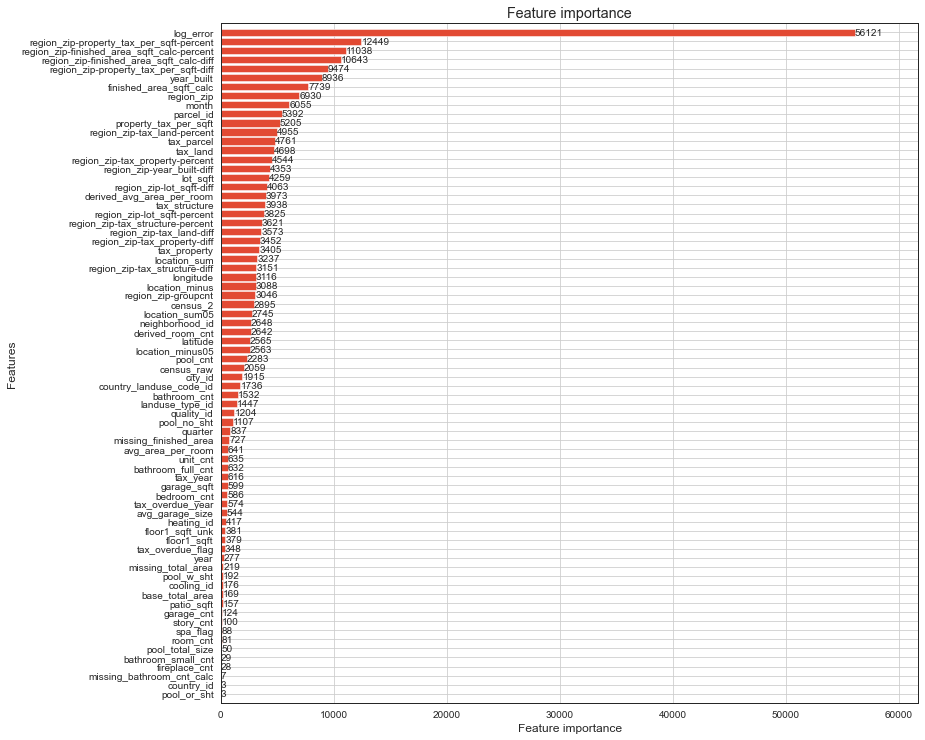

In [18]:
# Plot LightGBM feature importance
lgb.plot_importance(model, height=0.8, figsize=(12.5, 12.5), ignore_zero=False);

# Train on all data + Make predictions

In [19]:
# Train LightGBM on all given training data (preparing for submission)
del params['early_stopping_rounds']
params['num_boost_round'] = 1250  # roughly chosen based on public leaderboard score
print(params)

outlier_threshold = 0.4
mask = (abs(lgb_y) <= outlier_threshold)
lgb_X = lgb_X[mask, :]
lgb_y = lgb_y[mask]

lgb_train_set = lgb.Dataset(lgb_X, label=lgb_y, feature_name=feature_names)
print("lgb_X: {}".format(lgb_X.shape))
print("lgb_y: {}".format(lgb_y.shape))

np.random.seed(42)
random.seed(36)
model = lgb.train(params, lgb_train_set, verbose_eval=True, categorical_feature=categorical_indices)

# Sanity check: make sure the model score is reasonable on a small portion of the data
print("score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

{'objective': 'regression', 'metric': 'mae', 'num_threads': 4, 'boosting_type': 'gbdt', 'num_boost_round': 1250, 'learning_rate': 0.003, 'num_leaves': 127, 'min_data': 150, 'min_hessian': 0.001, 'max_depth': -1, 'max_bin': 255, 'sub_feature': 0.5, 'bagging_fraction': 0.7, 'bagging_freq': 50, 'min_data_per_group': 100, 'cat_smooth': 15.0, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'feature_fraction_seed': 2, 'bagging_seed': 3}
lgb_X: (164299, 74)
lgb_y: (164299,)
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11255
[LightGBM] [

In [26]:
%%time
file_name = '/Users/charles/Desktop/iFixerup/zr1/submission/final_lgb_single.csv'
submission, pred_2016, pred_2017 = lgbm_mod.predict_and_export([model], features_2016, features_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147  0.0065  0.0065  0.0065  0.0061  0.0061  0.0061
1  10759547  0.0053  0.0053  0.0053  0.0049  0.0049  0.0049
2  10843547  0.0056  0.0056  0.0056  0.0039  0.0039  0.0039
3  10859147  0.0001  0.0001  0.0001 -0.0002 -0.0002 -0.0002
4  10879947 -0.0021 -0.0021 -0.0021 -0.0020 -0.0020 -0.0020
CPU times: user 6min 36s, sys: 10.9 s, total: 6min 47s
Wall time: 2min 27s


# Ensemble Training and Prediction

In [28]:
# Remove outliers (if any) from training data
outlier_threshold = 0.4
mask = (abs(lgb_y) <= outlier_threshold)
lgb_X = lgb_X[mask, :]
lgb_y = lgb_y[mask]
lgb_train_set = lgb.Dataset(lgb_X, label=lgb_y, feature_name=feature_names)
print("lgb_X: {}".format(lgb_X.shape))
print("lgb_y: {}".format(lgb_y.shape))

# del params['early_stopping_rounds']
del params['feature_fraction_seed']
del params['bagging_seed']
params['num_boost_round'] = 1250

# Train multiple models
bags = 5
models = []
for i in range(bags):
    print("Start training model {}".format(i))
    params['seed'] = i
    np.random.seed(42)
    random.seed(36)
    model = lgb.train(params, lgb_train_set, verbose_eval=False, categorical_feature=categorical_indices)
    models.append(model)
    
# Sanity check (make sure scores on a small portion of the dataset are reasonable)
for i, model in enumerate(models):
    print("model {}: {}".format(i, abs(model.predict(X_val) - y_val).mean() * 100))

# Save the trained models to disk
# save_models(models)

# models = load_models(['checkpoints/lgb_' + str(i) for i in range(5)])  # load pretrained models

lgb_X: (164299, 74)
lgb_y: (164299,)
Start training model 0


/Users/charles/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/charles/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [2, 15, 24, 71, 72, 73]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11255
[LightGBM] [Info] Number of data points in the train set: 164299, number of used features: 74
[LightGBM] [Info] Start training from score 0.007873
Start training model 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11255
[LightGBM] [Info] Number of data point

In [30]:
# Make predictions and export results
file_name = '/Users/charles/Desktop/iFixerup/zr1/submission/final_lgb_ensemble_x5.csv'
submission, pred_2016, pred_2017 = lgbm_mod.predict_and_export(models, features_2016, features_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Start model 1 (2016)
Start model 1 (2017)
Start model 2 (2016)
Start model 2 (2017)
Start model 3 (2016)
Start model 3 (2017)
Start model 4 (2016)
Start model 4 (2017)
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147  0.0079  0.0079  0.0079  0.0071  0.0071  0.0071
1  10759547  0.0067  0.0067  0.0067  0.0059  0.0059  0.0059
2  10843547  0.0058  0.0058  0.0058  0.0044  0.0044  0.0044
3  10859147 -0.0009 -0.0009 -0.0009 -0.0008 -0.0008 -0.0008
4  10879947 -0.0027 -0.0027 -0.0027 -0.0023 -0.0023 -0.0023
